<a href="https://colab.research.google.com/github/rohitshukla01/PY-VERA_EXAMPLE/blob/main/Vera_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

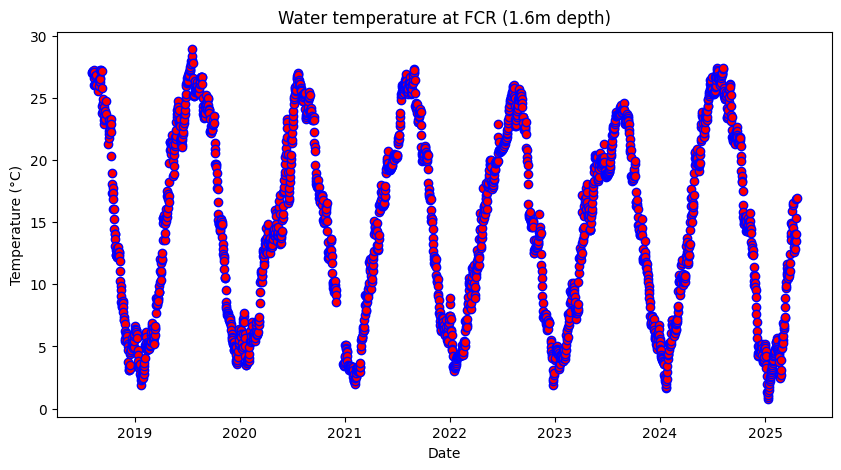

In [15]:
from IPython import get_ipython
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import os
from google.colab import drive
import requests
from io import StringIO
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="findfont: Font family.*")
from sklearn.linear_model import LinearRegression
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.packages import importr, isinstalled
import seaborn as sns
import logging
from sklearn.metrics import r2_score
from rpy2.rinterface_lib.callbacks import logger as rpy2_logger
rpy2_logger.setLevel(logging.ERROR)


###############################################################################################
# R Packages installations 'Uncomment' if you haven't run it before in your session
###############################################################################################

#!R -e "install.packages(c('reticulate','dplyr','arrow'), repos='http://cran.us.r-project.org')"
#!R -e "remotes::install_github('LTREB-reservoirs/vera4castHelpers')"

################ Reading and Visualizing the target variable ###################################

# Download and read targets data
targets_url = 'https://renc.osn.xsede.org/bio230121-bucket01/vera4cast/targets/project_id=vera4cast/duration=P1D/daily-insitu-targets.csv.gz'
targets = pd.read_csv(targets_url, compression='gzip')


####  'Uncomment' to get variable names from the list of target variables.  #############

#unique_variables = targets['variable'].unique()

# Print the unique variable names
#print("Unique Variable Names:")
#for variable_name in unique_variables:
#    print(variable_name)


# Create subplots based on the number of variables
#fig, axes = plt.subplots(len(unique_variables), 1, figsize=(10, 5 * len(unique_variables)), sharex=True)

# Iterate through unique variables and plot on respective subplots
#for i, variable_name in enumerate(unique_variables):
#    subset = targets[targets['variable'] == variable_name]
#    axes[i].scatter(pd.to_datetime(subset['datetime']), subset['observation'])
#    axes[i].set_title(f'{variable_name} at FCR')
#    axes[i].set_ylabel(variable_name)  # Set y-axis label to variable name

# Adjust layout and show plot
#plt.tight_layout()
#plt.show()


# Read site metadata
site_meta_url = "https://raw.githubusercontent.com/LTREB-reservoirs/vera4cast/main/vera4cast_field_site_metadata.csv"
site_list = pd.read_csv(site_meta_url)

# Filter for Falling Creek Reservoir (fcre) and temperature data
site_list = site_list[site_list['site_id'] == 'fcre']
targets = targets[
    (targets['site_id'] == 'fcre') &
    (targets['variable'] == 'Temp_C_mean') &
    (targets['duration'] == 'P1D') &
    (targets['depth_m'] == 1.6)
]

# Visualize temperature data
plt.figure(figsize=(10, 5))
plt.scatter(pd.to_datetime(targets['datetime']), targets['observation'],color='#FF0000',edgecolor='blue')
plt.title('Water temperature at FCR (1.6m depth)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.show()

In [16]:
# Load required R packages
base = importr('base')
lubridate = importr('lubridate')
dplyr = importr('dplyr')
vera4castHelpers = importr('vera4castHelpers')

# Set up dates
forecast_date = datetime.today().date()
noaa_date = forecast_date - timedelta(days=1)

# Convert Python dates to R dates
ro.globalenv['forecast_date'] = base.as_Date(str(forecast_date))
ro.globalenv['noaa_date'] = base.as_Date(str(noaa_date))


print("Fetching NOAA Stage 3 data...")

# --- Historical Weather Data ---
ro.r('''
site_list <- data.frame(site_id=c("fcre"))
historical_weather_s3 <- vera4castHelpers::noaa_stage3()
variables <- c("air_temperature")
historical_weather <- historical_weather_s3 |>
  dplyr::filter(site_id %in% site_list$site_id,
                variable %in% variables) |>
  dplyr::collect()
''')

historical_weather_df = ro.globalenv['historical_weather']
historical_weather_df = pandas2ri.rpy2py(historical_weather_df)

historical_weather_df = (
    historical_weather_df
    .assign(datetime=lambda x: pd.to_datetime(x['datetime']).dt.date)
    .groupby(['datetime', 'site_id', 'variable'], as_index=False)
    .agg(prediction=('prediction', 'mean'))  # Directly aggregate 'prediction'
    .sort_values('datetime')
    .reset_index(drop=True)
)

print(historical_weather_df.head())

# --- Future Weather Data ---
ro.r('''
forecast_date <- Sys.Date()
noaa_date <- forecast_date - lubridate::days(1)
future_weather_s3 <- vera4castHelpers::noaa_stage2(start_date = as.character(noaa_date))
future_weather <- future_weather_s3 |>
  dplyr::filter(datetime >= forecast_date,
                site_id %in% c("fcre"),
                variable == "air_temperature") |>
  dplyr::collect()
# Rename prediction to air_temperature for consistency
if ("prediction" %in% colnames(future_weather)) {
  future_weather <- future_weather |>
    dplyr::rename(air_temperature = prediction)
}
''')

future_weather_df = ro.globalenv['future_weather']
future_weather_df = pandas2ri.rpy2py(future_weather_df)

future_weather_df['datetime'] = pd.to_datetime(future_weather_df['datetime'])
future_weather_df['air_temperature'] = future_weather_df['air_temperature']
#print(future_weather_df.head())

Fetching NOAA Stage 3 data...
     datetime site_id         variable  prediction
0  2020-10-01    fcre  air_temperature  286.982631
1  2020-10-02    fcre  air_temperature  285.148455
2  2020-10-03    fcre  air_temperature  283.012745
3  2020-10-04    fcre  air_temperature  284.183651
4  2020-10-05    fcre  air_temperature  285.347794


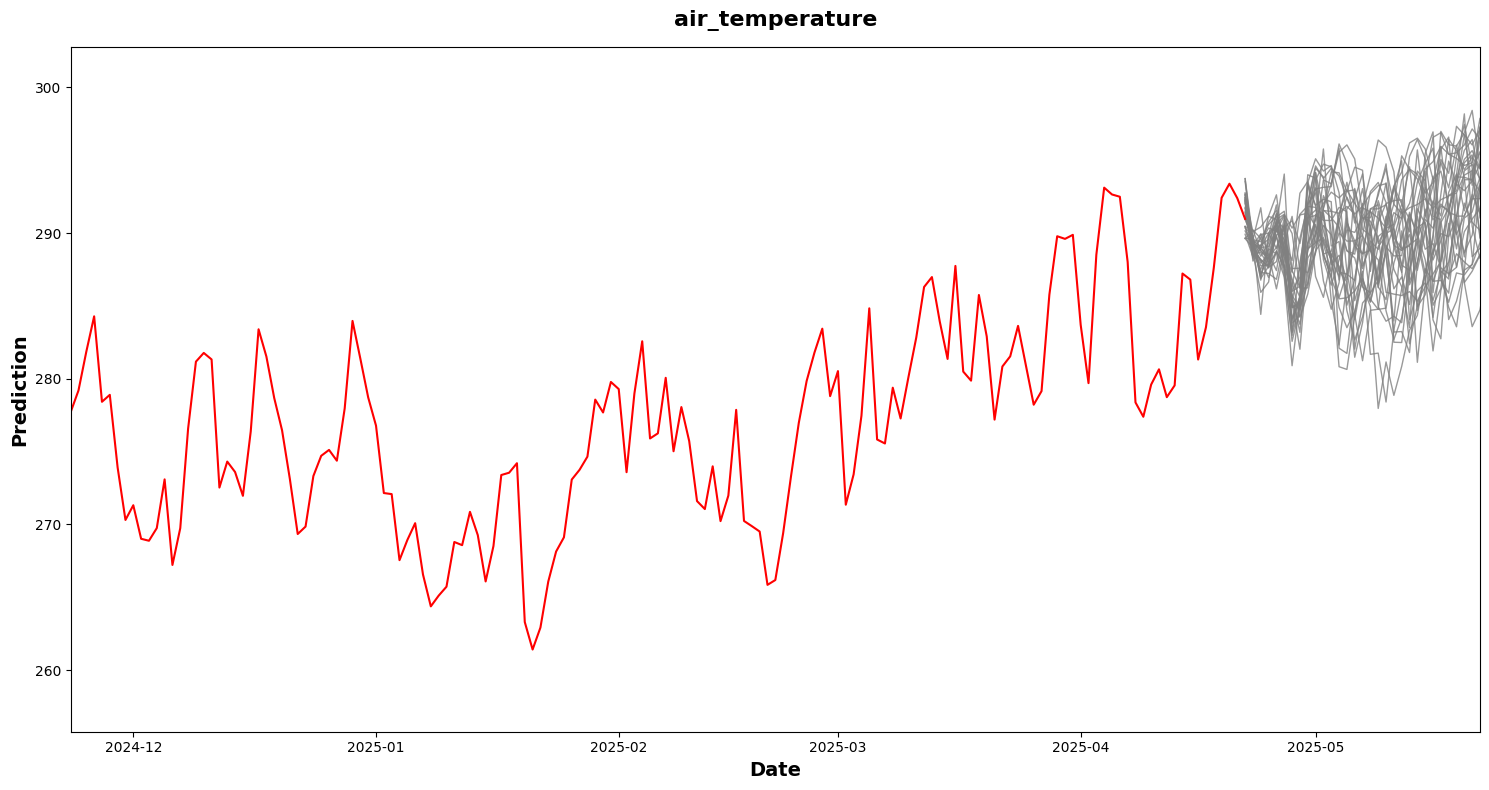

In [17]:
# --- Future Weather Daily Aggregation ---
future_weather_daily = (
    future_weather_df
    .assign(datetime=lambda x: pd.to_datetime(x['datetime']).dt.date)
    .groupby(['datetime', 'site_id', 'variable', 'parameter'])['air_temperature']
    .mean()
    .reset_index()
    .sort_values(['parameter', 'datetime'])
)

#print(future_weather_daily.head())

# --- Plotting Function ---
def plot_weather_comparison(historical_weather, future_weather, forecast_date, method='interpolate'):  # Add method parameter
    """
    Plots historical and future weather data.

    Args:
        historical_weather (pd.DataFrame): DataFrame containing historical weather data.
        future_weather (pd.DataFrame): DataFrame containing future weather data.
        forecast_date (datetime.date): The forecast date.
        method (str, optional): Method to handle missing values in future data.
                                 Can be 'interpolate' or 'drop'. Defaults to 'interpolate'.
    """
    fig, ax = plt.subplots(figsize=(15, 8))

    # Plot future weather ensemble members
    for param in future_weather['parameter'].unique():
        subset = future_weather[future_weather['parameter'] == param]

        if method == 'interpolate':
            # Interpolate to handle missing values
            subset = subset.set_index('datetime').resample('D').asfreq()
            subset['air_temperature'] = subset['air_temperature'].interpolate(method='linear')
            subset = subset.reset_index()
        elif method == 'drop':
            # Drop rows with NaN values in 'air_temperature' before plotting
            subset = subset.dropna(subset=['air_temperature'])
        else:
            raise ValueError("Invalid method. Choose 'interpolate' or 'drop'.")


        ax.plot(subset['datetime'], subset['air_temperature'],
                color='gray', alpha=0.8, linewidth=1.0)

  # Rename 'prediction' to 'air_temperature' in historical_weather
    historical_weather = historical_weather.rename(columns={'prediction': 'air_temperature'})

    # Directly use 'air_temperature' for plotting (removed plot_col)
    historical_weather = historical_weather.dropna(subset=['air_temperature'])
    ax.plot(historical_weather['datetime'], historical_weather['air_temperature'],
            color='red', linewidth=1.5)
  # Formatting
    title = historical_weather['variable'].iloc[0] if 'variable' in historical_weather.columns else 'Air Temperature'
    ax.set_title(title, fontweight='bold', fontsize=16, pad=15)
    ax.set_xlim([forecast_date - timedelta(days=150), forecast_date + timedelta(days=30)]) # Change it to see the past date
    ax.grid(False)
    ax.set_ylabel('Prediction', fontweight='bold', fontsize=14)
    ax.set_xlabel('Date', fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.show()

# Usage with your DataFrames, choose method: 'interpolate' or 'drop'
plot_weather_comparison(historical_weather_df, future_weather_df, forecast_date, method='interpolate')  # Using 'interpolate' method

In [18]:
def wide_format(df, index_cols):
    """Converts a DataFrame to wide format."""
    values_col = 'prediction' if 'prediction' in df.columns else 'air_temperature'
    # Convert Kelvin to Celsius if 'air_temperature' is the values column
    if values_col in ['air_temperature', 'prediction']:
        df[values_col] = df[values_col] - 273.15
    # Format datetime to date only
    df['datetime'] = pd.to_datetime(df['datetime']).dt.date

    df_wide = (
        df.pivot_table(
            index=index_cols,
            columns='variable',
            values=values_col,
            aggfunc='mean'
        )
        .reset_index()
        .rename_axis(None, axis=1)
    )
    return df_wide

# --- Historical Weather Data (Wide Format) ---
historical_weather_wide = wide_format(historical_weather_df, ['datetime', 'site_id'])

# --- Future Weather Data (Wide Format) ---
future_weather_wide = wide_format(future_weather_df, ['datetime', 'site_id', 'parameter'])

print("Historical Weather:")
print(historical_weather_wide.head())

print("\nFuture Weather:")
print(future_weather_wide.head())

Historical Weather:
     datetime site_id  air_temperature
0  2020-10-01    fcre        13.832631
1  2020-10-02    fcre        11.998455
2  2020-10-03    fcre         9.862745
3  2020-10-04    fcre        11.033651
4  2020-10-05    fcre        12.197794

Future Weather:
     datetime site_id  parameter  air_temperature
0  2025-04-22    fcre        0.0        17.682941
1  2025-04-22    fcre        1.0        17.880717
2  2025-04-22    fcre        2.0        17.615942
3  2025-04-22    fcre        3.0        16.650614
4  2025-04-22    fcre        4.0        17.383620


In [19]:
# ————————————————————————————————————————————————
# Preparing data for Fitting the model
# ————————————————————————————————————————————————

# Ensure date-only columns
for df in (targets, historical_weather_df):
    df['datetime'] = pd.to_datetime(df['datetime']).dt.date

# Pivot targets to wide format (one column per variable)
targets_wide = (
    targets
    .pivot_table(
        index=['datetime', 'site_id', 'depth_m', 'duration'],
        columns='variable',
        values='observation',
        aggfunc='mean'
    )
    .reset_index()
)

# Merge in historical temperature and rename
targets_lm = (
    targets_wide
    .merge(
        historical_weather_df[['datetime', 'site_id', 'prediction']],
        on=['datetime', 'site_id'],
        how='left'
    )
    .rename(columns={'prediction': 'air_temperature'})
)

# Quick check
#print("Merged Data Structure:")
print(targets_lm.tail())


        datetime site_id  depth_m duration  Temp_C_mean  air_temperature
2392  2025-04-17    fcre      1.6      P1D    13.503430        10.386724
2393  2025-04-18    fcre      1.6      P1D    14.028957        14.464358
2394  2025-04-19    fcre      1.6      P1D    15.291631        19.274851
2395  2025-04-20    fcre      1.6      P1D    16.849979        20.240875
2396  2025-04-21    fcre      1.6      P1D    16.900887        19.248502


In [20]:
# ————————————————————————————————————————————————
# 1. Forecast setup & linear model
# ————————————————————————————————————————————————
forecast_date   = datetime.today().date()
forecast_horizon = 30
forecast_dates   = pd.date_range(start=forecast_date, periods=forecast_horizon)

# Prepare training data
train = targets_lm.dropna(subset=['air_temperature', 'Temp_C_mean'])
X_train = train[['air_temperature']].values
y_train = train['Temp_C_mean'].values

# Fit model
lin_model = LinearRegression().fit(X_train, y_train)
coef, intercept = lin_model.coef_[0], lin_model.intercept_
print(f"Linear Model: Temp_C = {coef:.2f} * AirTemp + {intercept:.2f}")


# ————————————————————————————————————————————————
# 2. Generate 30‑day ensemble forecasts
# ————————————————————————————————————————————————
forecast_list = []
for ts in forecast_dates:
    date = ts.date()
    drivers = future_weather_wide[
        (future_weather_wide['datetime'] == date) &
        (future_weather_wide['site_id'] == 'fcre')
    ]
    if drivers.empty:
        continue

    preds = lin_model.predict(drivers[['air_temperature']].values)
    fc = drivers.assign(
        datetime           = date,
        reference_datetime = forecast_date,
        depth_m            = 1.6,
        variable           = 'Temp_C_mean',
        family             = 'ensemble',
        prediction         = preds,
        duration           = 'P1D',
        project_id         = 'vera4cast'
    )[
        ['datetime','reference_datetime','site_id','depth_m',
         'variable','family','parameter','prediction','duration','project_id']
    ]
    forecast_list.append(fc)

forecast_df = pd.concat(forecast_list, ignore_index=True)

#N = future_weather_wide['parameter'].nunique()
#print(f"Ensemble size: {N}")


Linear Model: Temp_C = 0.78 * AirTemp + 5.22


<ipython-input-21-c28686414802>:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
<ipython-input-21-c28686414802>:28: UserWarning: 
The palette list has fewer values (1) than needed (31) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


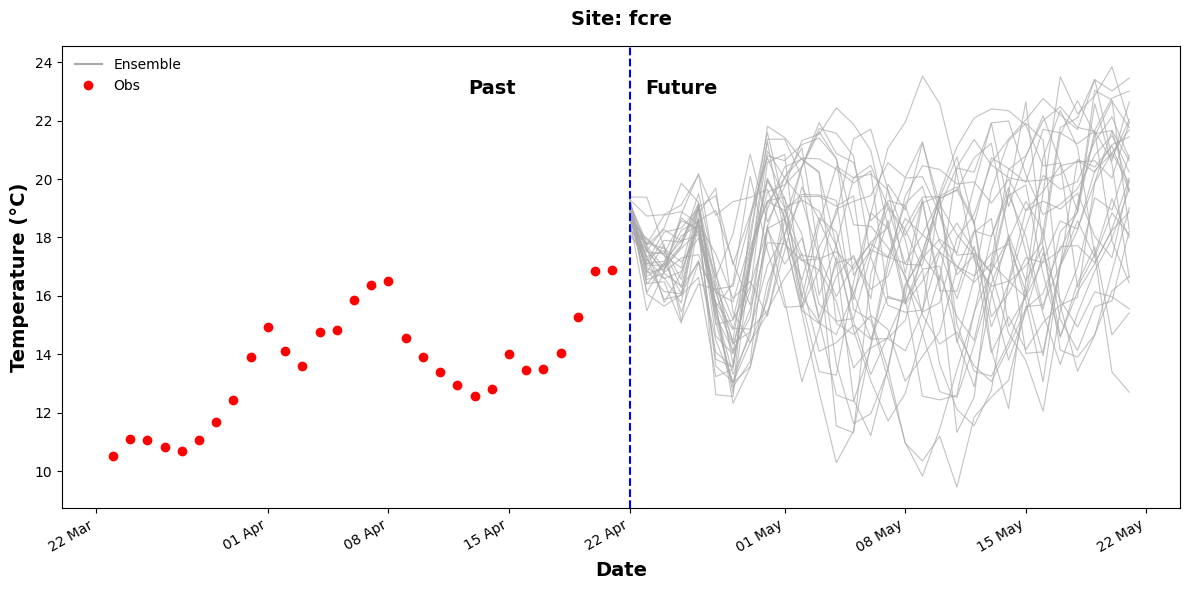

In [21]:
# ————————————————————————————————————————————————
# 3. Plotting function
# ————————————————————————————————————————————————
def plot_forecasts(historical, forecasts, target_obs, ref_date, site_id='fcre'):
    """
    Plots historical observations vs. ensemble forecasts.

    Parameters:
      historical : pd.DataFrame  (must have 'datetime' & 'prediction' columns)
      forecasts  : pd.DataFrame  (ensemble members with 'datetime','parameter','prediction')
      target_obs : pd.DataFrame  (observed 'observation' at matching dates)
      ref_date   : datetime.date  forecast origin date
      site_id    : str            site identifier (for title)
    """
    window_start = ref_date - timedelta(days=30)
    historical  = historical[
        (historical['datetime'] >= window_start) &
       (historical['datetime'] <= ref_date)
    ]
    # Convert 'datetime' column to datetime.date before comparison
    target_obs['datetime'] = pd.to_datetime(target_obs['datetime']).dt.date
    target_obs  = target_obs[
       (target_obs['datetime'] >= window_start) &
       (target_obs['datetime'] <= ref_date)
   ]

    fig, ax = plt.subplots(figsize=(12,6))
    sns.lineplot(
        data=forecasts,
        x='datetime', y='prediction', hue='parameter',
        palette=['darkgrey'], alpha=0.7, linewidth=0.8,
        legend=False, ax=ax, ci=None
    )
    ax.scatter(
        pd.to_datetime(target_obs['datetime']),
        target_obs['observation'],
        color='red', label='Observations'
    )
    ax.axvline(ref_date, color='blue', linestyle='--', linewidth=1.5)
    ax.text(ref_date - timedelta(days=8), target_obs['observation'].max()+6,
            "Past", ha='center',fontweight='bold',fontsize=14)
    ax.text(ref_date + timedelta(days=3), target_obs['observation'].max()+6,
            "Future", ha='center',fontweight='bold',fontsize=14)

    ax.set_title(f"Site: {site_id}", pad=15,fontweight='bold',fontsize=14)
    ax.set_xlabel("Date",fontweight='bold',fontsize=14)
    ax.set_ylabel("Temperature (°C)",fontweight='bold',fontsize=14)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    fig.autofmt_xdate()
    ax.grid(False)
    ax.legend(loc='upper left', frameon=False,
              handles=[
                  plt.Line2D([], [], color='darkgrey', label='Ensemble'),
                  plt.Line2D([], [], marker='o', color='red',
                             linestyle='None', label='Obs')
              ])
    plt.tight_layout()
    plt.show()

# ————————————————————————————————————————————————
# 4. plot
# ————————————————————————————————————————————————
forecast_temp = forecast_df[forecast_df['variable']=='Temp_C_mean']
obs = targets[
    (targets['depth_m']==1.6) &
    (targets['variable']=='Temp_C_mean')
]

plot_forecasts(
    historical=historical_weather_df.rename(columns={'prediction':'observation'})[ ['datetime','observation'] ],
    forecasts = forecast_temp,
    target_obs=obs,
    ref_date  = forecast_date
)

In [23]:
################################################################
# Oraganising/Formatting, and saving the files for model submission
###############################################################

model_id = 'example_ID'  # Change your model

# Directly modify the original forecast_df
forecast_df['model_id'] = model_id
forecast_df['reference_datetime'] = forecast_date
forecast_df['family'] = 'ensemble'
forecast_df['parameter'] = forecast_df['parameter'].astype(str)
forecast_df['duration'] = 'P1D'
forecast_df['depth_m'] = 1.6
forecast_df['project_id'] = 'vera4cast'

# Select the desired columns in the desired order
forecast_df_standard = forecast_df[[
    'datetime', 'reference_datetime', 'site_id', 'duration', 'family',
    'parameter', 'variable', 'prediction', 'depth_m', 'model_id', 'project_id'
]]

# Define the directory and file paths
save_here = '/content/Forecasts'  # Use '/content/' for Colab You can change to preferred path here
forecast_file = os.path.join(save_here, f"{forecast_date}-{model_id}.csv")

# Create directory if it doesn't exist
os.makedirs(save_here, exist_ok=True)
print(f"Directory '{save_here}' created or already exists.") # More concise message

# Write the forecast DataFrame to a CSV file
forecast_df_standard.to_csv(forecast_file, index=False)
print(f"Forecast saved to '{forecast_file}'.")

# Optional: Download the file (if you want to keep it after the session)
# from google.colab import files
# files.download(forecast_file)

Directory '/content/Forecasts' created or already exists.
Forecast saved to '/content/Forecasts/2025-04-22-example_ID.csv'.


In [26]:
################################################################
# Validating and Submitting the model using R package
###############################################################

# Import the vera4castHelpers package
vera4castHelpers = importr('vera4castHelpers')

# Validation of the file for the submission
ro.r(f"vera4castHelpers::forecast_output_validator(forecast_file = '{forecast_file}')")

# Submission 'Uncomment' to submit your Forecast

#ro.r(f"vera4castHelpers::submit(forecast_file = '{forecast_file}')")

✔ file has model_id column
✔ forecasted variables found correct variable + prediction column
✔ file has correct family and parameter columns
✔ file has site_id column
✔ file has datetime column
✔ file has correct datetime column
✔ file has duration column
✔ file has depth column
✔ file has project_id column
✔ file has reference_datetime column


1


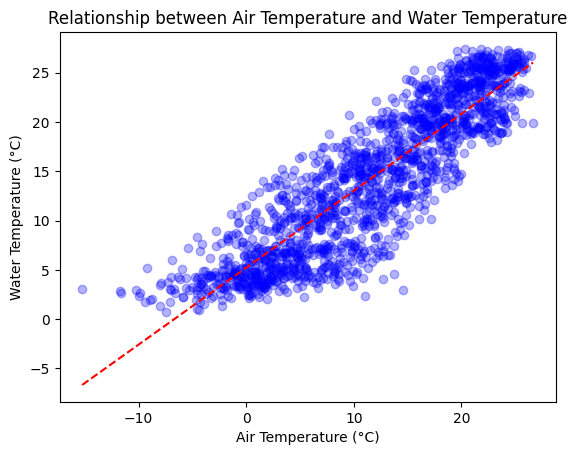

In [27]:
# Assuming 'targets_lm' is your DataFrame
x = targets_lm['air_temperature']
y = targets_lm['Temp_C_mean']

# Choose the color for the dots (e.g., 'blue', 'green', '#FF5733', etc.)
dot_color = 'blue'

# Remove rows with NaN values in 'air_temperature' and 'Temp_C_mean'
valid_data = targets_lm.dropna(subset=['air_temperature', 'Temp_C_mean'])
x = valid_data['air_temperature']
y = valid_data['Temp_C_mean']

# Create the scatter plot
plt.scatter(x, y, color=dot_color, alpha=0.3)

# Fit the linear regression model
model = LinearRegression()
model.fit(x.values.reshape(-1, 1), y)  # Reshape x for sklearn

# Get the regression line coordinates
x_line = np.linspace(x.min(), x.max(), 100)
y_line = model.predict(x_line.reshape(-1, 1))

# Calculate R-squared
r_squared = r2_score(y, model.predict(x.values.reshape(-1, 1)))

# Plot the regression line (adjust color and linestyle as needed)
plt.plot(x_line, y_line, color='red', linestyle='--')

# Add labels and title
plt.title('Relationship between Air Temperature and Water Temperature')
plt.xlabel('Air Temperature (°C)')
plt.ylabel('Water Temperature (°C)')

# Add legend to display R-squared
#plt.legend()

# Show the plot
plt.show()